# Task 1 
По заданному набору ридов в формате FASTQ и параметру k, который соответствует длине k-меров, построить граф Де Брюина, некоторый путь в котором соответствовал бы возможной подстроке в исходном геноме. Не забывайте про запоминание покрытия каждого k-мера, а так же про сами подстроки, которые соответствуют каждому ребру. В остальном граф полностью соответствует тому, что был описан в лекции.

In [1]:
class Node:
    """ Вершина в графе Де Брюина """
    def __init__(self, lab):
        self.label = lab
        self.indegree = 0
        self.outdegree = 0

class Edge:
    """ Ребро в графе Де Брюина """
    def __init__(self, lab, coverage=1):
        self.label = lab
        self.coverage = coverage #покрытие
        self.v1 = lab[:-1]
        self.v2 = lab[1:]
        
def read_reads(fname):
    """ Одна строка во входном файле соответствует одному риду """
    f = open(fname, 'r')
    lines = f.readlines()
    f.close()
    reads = []

    for line in lines:
        if line[0] != '>':
            reads = reads + [line.rstrip()]

    return reads

def construct_graph(reads, k):
    """ Построение графа Де Брюина из наборов коротких чтений с ридом длины k"""
    edges = dict()
    vertices = dict()

    for read in reads:
        i = 0
        while i+k < len(read):
            v1 = read[i:i+k]
            v2 = read[i+1:i+k+1]
            
            if v1 in edges.keys():
                for z in edges[v1]: #если есть путь!!!!
                    if z.label == v1[0]+v2:
                        z.coverage += 1
                        break
                else:
                    edges[v1] += [Edge(v1[0]+v2)] #если нет пути!!!!
                    vertices[v1].outdegree += 1
                    if v2 not in edges.keys():    #если даже не было v2!!!!
                        vertices[v2] = Node(v2)
                        edges[v2] = []
                    vertices[v2].indegree += 1
            else:
                vertices[v1] = Node(v1) 
                vertices[v1].outdegree += 1
                edges[v1] = []
                edges[v1] += [Edge(v1[0]+v2)]
                if v2 not in edges.keys():
                    vertices[v2] = Node(v2)
                    edges[v2] = []
                vertices[v2].indegree += 1
            i += 1

    return (vertices, edges)

def output_contigs(g):
    """ Поиск эйлерова пути в графе - генома"""
    V = g[0]
    E = g[1]

    start = list(V.keys())[0]
    for k in V.keys():
        if V[k].indegree < V[start].indegree:
            start = k

    contig = start
    current = start
    while len(E[current]) > 0:
        # Pick the next node to be traversed (for now, at random)
        next = E[current][0]
        del E[current][0]
        contig += next.label[-1]
        current = next.label

    return contig

def print_graph(g):
    """ Print the information in the graph to be (somewhat) presentable """
    V = g[0]
    E = g[1]
    for k in V.keys():
        print("name: ", V[k].label, ". indegree: ", V[k].indegree, ". outdegree: ", V[k].outdegree)
        print("Edges: ")
        for e in E[k]:
            print(e.label, e.coverage)
        print()



test = ['abczefg', 'abcdefg']
g = construct_graph(test, 2)

name:  ab . indegree:  0 . outdegree:  1
Edges: 
abc 2

name:  bc . indegree:  1 . outdegree:  2
Edges: 
bcz 1
bcd 1

name:  cz . indegree:  1 . outdegree:  1
Edges: 
cze 1

name:  ze . indegree:  1 . outdegree:  1
Edges: 
zef 1

name:  ef . indegree:  2 . outdegree:  1
Edges: 
efg 2

name:  fg . indegree:  1 . outdegree:  0
Edges: 

name:  cd . indegree:  1 . outdegree:  1
Edges: 
cde 1

name:  de . indegree:  1 . outdegree:  1
Edges: 
def 1



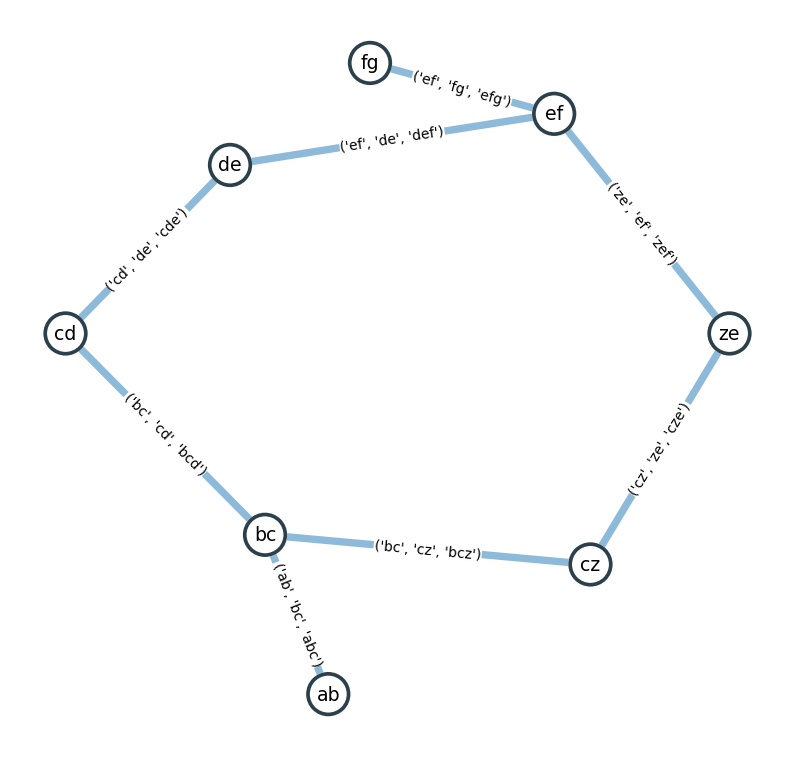

In [2]:
from netgraph import MultiGraph 
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure

figure(figsize=(10, 10))
lst =[]
G = nx.MultiGraph()
G.add_nodes_from(g[0].keys())
for z in g[1]:
    i = g[1][z]
    for obj in i:
        lst.append((obj.v1, obj.v2, obj.label))
G.add_edges_from(lst)

MultiGraph(G, node_labels=True, edge_labels= True, edge_color='tab:blue')
plt.show()

# Task 2


In [5]:
def squeeze(g):
    """ Сжатие графа """
    edges = g[1]
    vertices = g[0]
    i=0
    while i != len(list(vertices.keys())):
        lst=[]
        par= vertices[list(vertices.keys())[i]].label
        sque = -1
        for indx, edg_1 in enumerate(edges[par]):
            if len(edges[edg_1.v2]) == 1:
                edg_2 = edges[edg_1.v2][0]
                if vertices[edg_1.v2].indegree == 1 and vertices[edg_1.v2].outdegree == 1:
                    c1 = edg_1.coverage * len(edg_1.label)
                    c2 = edg_2.coverage * len(edg_2.label)
                    edg_1 = Edge(edg_1.label + edg_2.v2[-1], coverage = -1) #изменили грань edg_1
                    edg_1.v2 = edg_2.v2
                    edg_1.coverage = (c1 + c2)/len(edg_1.label)
                    lst.append(edg_1)
                    del edges[edg_2.v1]
                    del vertices[edg_2.v1]
                    sque = 1  
        if sque == -1:
            i+=1
        else:
            del edges[par]
            edges[par] = lst 
    return(vertices, edges)

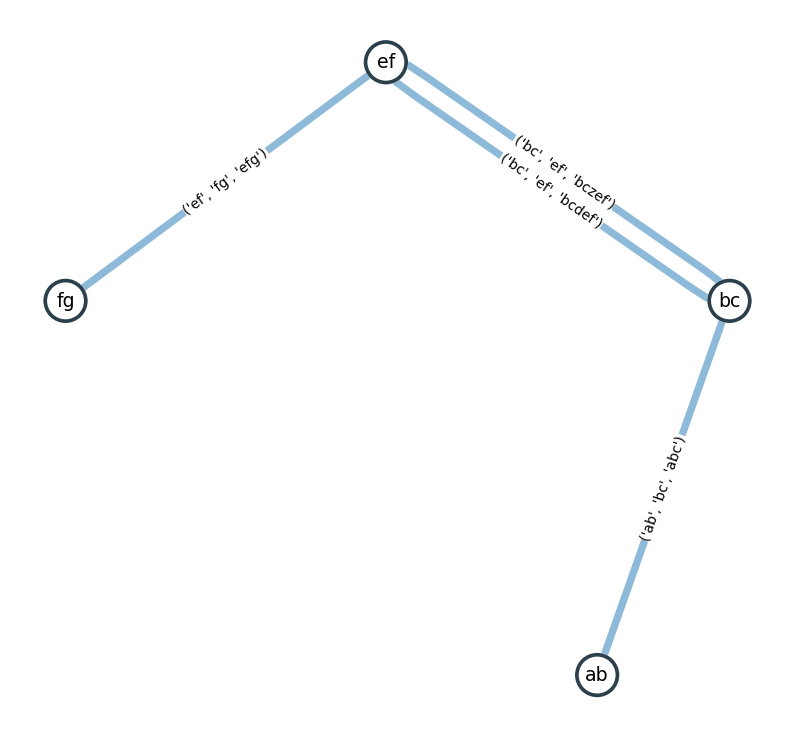

In [6]:
from netgraph import MultiGraph 
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure

Sq = squeeze(g)
figure(figsize=(10, 10))
lst =[]
G = nx.MultiGraph()
G.add_nodes_from(Sq[0].keys())
for z in Sq[1]:
    i = Sq[1][z]
    try:
        for obj in i:
            lst.append((obj.label[:2], obj.label[-2:], obj.label))
    except:
        lst.append((i.v1, i.v2, i.label))
G.add_edges_from(lst)

MultiGraph(G, node_labels=True, edge_labels= True, edge_color='tab:blue')
plt.show()